In [1]:
import gzip

print(f"Print first 10 lines of the dataset:")
printed = 0

# Caricamento del dataset
samples = []
with gzip.open("dataset/wiki-RfA.txt.gz", "rt", encoding="utf-8", errors="ignore") as f:
    block = {}
    for line in f:
        line = line.strip()

        if printed < 10: 
            print(line)
            printed += 1

        if not line:
            if "SRC" in block and "TGT" in block and "VOT" in block:
                samples.append((block["SRC"], block["TGT"], int(block["VOT"])))
            block = {}
        else:
            key, value = line.split(":", 1)
            block[key] = value.strip()

print(f"\nCampioni totali: {len(samples)}")

Print first 10 lines of the dataset:
SRC:Steel1943
TGT:BDD
VOT:1
RES:1
YEA:2013
DAT:23:13, 19 April 2013
TXT:'''Support''' as co-nom.

SRC:Cuchullain
TGT:BDD

Campioni totali: 198275


In [2]:
from sklearn.preprocessing import LabelEncoder
import torch

# Codifica utenti come ID numerici
users = list(set([s[0] for s in samples] + [s[1] for s in samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))

print(f"Numero di utenti unici: {len(users)}")
print(list(user_map.items())[:10])  # Stampa i primi 10 mapping utente -> ID

Numero di utenti unici: 11381
[('', np.int64(0)), ('Paradiso', np.int64(7436)), ('Ganymead', np.int64(3753)), ('Orizon', np.int64(7308)), ('Zero0000', np.int64(11001)), ('ChesPal', np.int64(1870)), ('JHunterJ', np.int64(4713)), ('Mattb90', np.int64(6246)), ('TJRC', np.int64(9486)), ('Schmausschmaus', np.int64(8626))]


In [3]:
import torch
from torch_geometric.data import Data

def create_pyg_data(samples, user_map):
    num_nodes = len(user_map)
    
    # PyG richiede edge_index di forma 2 x num_edges, ogni colonna rappresenta un arco diretto.
    
    src_list = []
    tgt_list = []
    edge_attr_list = [] # Opzionale: se volessimo usare il peso del voto come feature dell'arco in input
    
    for src, tgt, vot in samples:
        if src in user_map and tgt in user_map:
            u, v = user_map[src], user_map[tgt]
            src_list.append(u)
            tgt_list.append(v)

    edge_index = torch.tensor([src_list, tgt_list], dtype=torch.long)
    
    # Features iniziali dei nodi sono semplici ID
    x = torch.arange(num_nodes, dtype=torch.long) 
    
    data = Data(x=x, edge_index=edge_index)
    return data

data = create_pyg_data(samples, user_map)
print(f"Grafo creato con {data.num_nodes} nodi e {data.num_edges} archi.")

Grafo creato con 11381 nodi e 198275 archi.


In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv

class GNNVotePredictor(nn.Module):
    def __init__(self, num_nodes, emb_dim=64, hidden_dim=128, out_dim=3):
        """
        Args:
            num_nodes: Numero totale di utenti unici.
            emb_dim: Dimensione dell'embedding iniziale (learnable).
            hidden_dim: Dimensione delle feature nascoste della GNN.
            out_dim: Numero di classi di voto (-1, 0, 1) -> 3 classi.
        """
        super().__init__()
        
        # Sostituisce le features one-hot con vettori densi
        self.node_emb = nn.Embedding(num_nodes, emb_dim)
        
        # Graph layers
        self.conv1 = SAGEConv(emb_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        
        # Link Predictor
        # Input dim è hidden_dim * 2 perché concateniamo sorgente e target.
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, out_dim)
        )

    def forward(self, x, edge_index, src_batch, tgt_batch):
        """
        Args:
            x: Input node features/IDs (tutti i nodi).
            edge_index: La struttura completa del grafo per il message passing.
            src_batch: Indici degli utenti votanti nel batch corrente.
            tgt_batch: Indici degli utenti candidati nel batch corrente.
        """
        x = self.node_emb(x)
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
                
        # Seleziono solo i nodi coinvolti nelle votazioni che stiamo predicendo ora
        h_src = x[src_batch]
        h_tgt = x[tgt_batch]
        
        # Concatena e classifica
        edge_feat = torch.cat([h_src, h_tgt], dim=1)
        return self.mlp(edge_feat)

In [5]:
# Costruisci dataset
X = []
y = []
for src, tgt, vot in samples:
    if src in user_map and tgt in user_map:
        X.append([user_map[src], user_map[tgt]])
        y.append(vot)

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

In [6]:
from sklearn.model_selection import train_test_split

# Suddivisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # oppure mps per Mac 
num_users = len(user_map)
model = GNNVotePredictor(num_nodes=num_users).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# IMPORTANTE: Per evitare data leakage, l'edge_index usato per il message passing 
# dovrebbe idealmente essere solo quello del training set.
train_edge_index = X_train.t().to(device)

# Training Loop
for epoch in range(1, 51):
    model.train()
    total_loss = 0
    
    for xb, yb in train_loader:
        # xb contiene le coppie (src, tgt) del batch corrente
        # yb contiene le label (voti)
        xb, yb = xb.to(device), yb.to(device)
        
        src_batch = xb[:, 0]
        tgt_batch = xb[:, 1]
        
        # Tutti i nodi (0...N-1) servono come input per l'embedding layer
        all_nodes_idx = torch.arange(num_users, device=device)
        
        optimizer.zero_grad()
        
        out = model(all_nodes_idx, train_edge_index, src_batch, tgt_batch)
        
        # Loss calculation
        class_weights = torch.tensor([1.5, 1.0, 0.8]).to(device)
        loss = F.cross_entropy(out, yb + 1, weight=class_weights)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 462.9803
Epoch 2, Loss: 385.9590
Epoch 3, Loss: 366.7731
Epoch 4, Loss: 354.9966
Epoch 5, Loss: 346.9302
Epoch 6, Loss: 339.9258
Epoch 7, Loss: 334.3860
Epoch 8, Loss: 328.7694
Epoch 9, Loss: 324.7202
Epoch 10, Loss: 321.0222
Epoch 11, Loss: 317.7312
Epoch 12, Loss: 313.8631
Epoch 13, Loss: 311.3119
Epoch 14, Loss: 308.9729
Epoch 15, Loss: 306.2846
Epoch 16, Loss: 303.9893
Epoch 17, Loss: 301.3578
Epoch 18, Loss: 300.3136
Epoch 19, Loss: 297.8687
Epoch 20, Loss: 295.9513
Epoch 21, Loss: 294.6653
Epoch 22, Loss: 292.6144
Epoch 23, Loss: 291.8449
Epoch 24, Loss: 289.5952
Epoch 25, Loss: 287.9299
Epoch 26, Loss: 287.1544
Epoch 27, Loss: 285.5017
Epoch 28, Loss: 284.2662
Epoch 29, Loss: 283.7211
Epoch 30, Loss: 281.2674
Epoch 31, Loss: 280.3578
Epoch 32, Loss: 279.6844
Epoch 33, Loss: 278.7527
Epoch 34, Loss: 277.2028
Epoch 35, Loss: 276.6783
Epoch 36, Loss: 276.4499
Epoch 37, Loss: 274.1788
Epoch 38, Loss: 272.6664
Epoch 39, Loss: 272.5391
Epoch 40, Loss: 271.8385
Epoch 41,

GNN Classification Report:
              precision    recall  f1-score   support

      Oppose       0.57      0.72      0.63      8237
     Neutral       0.44      0.12      0.19      2633
     Support       0.88      0.87      0.88     28785

    accuracy                           0.79     39655
   macro avg       0.63      0.57      0.57     39655
weighted avg       0.79      0.79      0.78     39655



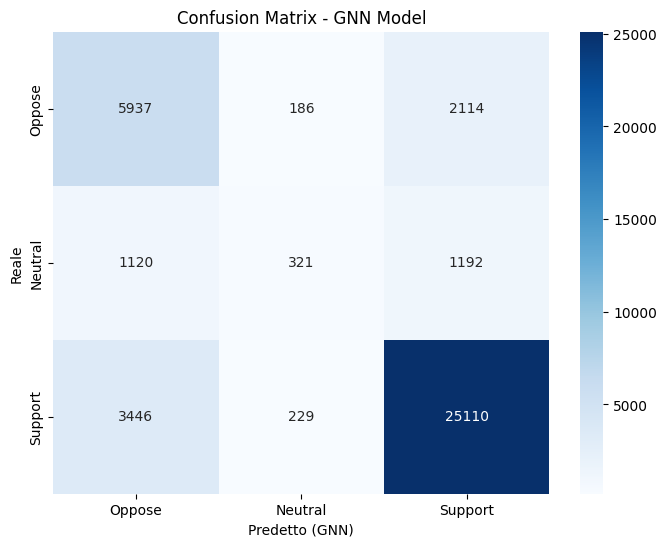

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

model.eval()

with torch.no_grad():
    X_eval = X_test.to(device)
    
    src_test = X_eval[:, 0]
    tgt_test = X_eval[:, 1]
    
    y_pred = model(all_nodes_idx, train_edge_index, src_test, tgt_test).argmax(dim=1).cpu().numpy()
    
    y_true = (y_test + 1).numpy() 

# Report di Classificazione
print("GNN Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Oppose", "Neutral", "Support"]))

# Matrice di Confusione
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Oppose", "Neutral", "Support"],
            yticklabels=["Oppose", "Neutral", "Support"])
plt.xlabel("Predetto (GNN)")
plt.ylabel("Reale")
plt.title("Confusion Matrix - GNN Model")
plt.show()